# **DIPLOMATURA UNIVERSITARIA EN CIENCIA DE DATOS**

# Módulo 5: Aprendizaje No Supervisado

## Técnicas de muestreo: Markov Chain Monte Carlo. Metropolis Hastings. Gibbs sampling.

## **Docentes:** Lic. Luis Duarte - Dra. Griselda Bobeda  - Dra. Magdalena Lucini

### Noviembre 2024, FaCENA - UNNE

### Contacto:  
* luis.duarte@comunidad.unne.edu.ar;
* griseldabobeda@gmail.com;
* mariamlucini@comunidad.unne.edu.ar

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## **5.Muestreo por Metropoltan-Hasting:**

En este procedimiento, trabajamos con cadenas de Markov y definimos los siguientes elementos:

- $Q(Y \mid X)$: una densidad de transición (propuesta) para $X$ y $Y$ de dimensión $p$, que nos permite simular fácilmente.
- $P(X)$: nuestra densidad objetivo, es decir, la distribución estacionaria a la que la cadena de Markov converge.

El algoritmo Metropolis-Hastings es un proceso iterativo que sigue tres pasos principales para determinar cómo moverse del estado actual $x$ al siguiente en el espacio de estados:

1. **Simular un valor candidato**  
   Generar $y \sim Q(Y \mid x)$, donde $y$ depende del estado actual $x$.

2. **Calcular la razón de aceptación**  
   $$  \alpha(y \mid x) = \min\left\{ \cfrac{P(y) Q(x \mid y)}{P(x) Q(y \mid x)}, 1 \right\}$$
   Esta razón determina la probabilidad de aceptar el candidato $y$.

3. **Decidir el siguiente estado**  
   Generar $u \sim \mathcal{U}(0,1)$.
   * Si $u \leq \alpha(y \mid x)$, el próximo estado será $y$.
   * Caso contrario, el estado permanece en $x$.


### **5.1 Caso Univariado:**
Sea $P(x)=3e^{-\frac{x^2}{2}} + e^{-\frac{(x-4)^2}{2}}$ la distribución de la cual queremos muestrear para estimar: $E_P\left[X\right]$ y $E_P\left[\sin\right]$ . Tengamos en cuenta que esta es una distribución no normalizada con una constante de normalización $Z$ que podemos calcular, pero dejémosla tal como está. ($Z\approx 10.0261955464$). Con una muestra de tamaño un millón, estime las esperanzas solicitadas.

In [ ]:
# Función objetivo
def P(x):
    return 3 * np.exp(-x*x/2) + np.exp(-(x - 4)**2/2)

In [ ]:
x_vals = np.linspace(-10, 10, 1000)
y_vals = P(x_vals)
plt.figure(1)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

In [ ]:
def fx(x):
  return x

def gx(x):
  return np.sin(x)

Recordemos que los valores reales son $E_P\left[X\right]\approx 10.02686647165$ y $E_P\left[\sin\right]\approx -1.15088010640$.

In [ ]:
Z=10.0261955464
true_expected_fx = 10.02686647165
true_expected_gx = -1.15088010640

La cadena de Markov necesita un tiempo para estabilizarse, lo que se conoce como la fase de calentamiento (burn-in). En general, se "tiran" las primeras 1000 muestras como parte de esta fase de calentamiento.

Aquí elegimos $Q(Y|X=x)$ como una distribución $\mathcal{N}(x,1)$ que en realidad es igual a $Q(X|Y=y)$ y debería cancelarse, pero lo dejamos incluido en el código para mayor claridad.

In [ ]:
def Q(t0,t1):
  return np.exp(-(t1 - t0)**2/2)/(np.sqrt(2 * np.pi))

In [ ]:
x0 = 0
xt = x0
samples = []
for i in range(1001000):
    y = np.random.normal(xt, 1)
    accept_prob = (P(y) * Q(xt, y))/(P(xt) * Q(y, xt))
    if np.random.uniform(0, 1) <= accept_prob:
        xt = y
    samples.append(xt)
burn_in = 1000
samples = np.array(samples[burn_in:])
expected_fx = np.mean(fx(samples))
expected_gx = np.mean(gx(samples))
expected_fx *= Z
expected_gx *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_fx, abs(expected_fx - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_gx, abs(expected_gx - true_expected_gx)))

Determinemos el histograma de las muestras obtenidas con el algoritmo de Metropolis-Hastings y comparémoslo con la distribución normalizada $P(x)$ subyacente.

In [ ]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, density=True, label='bins')
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

 Es evidente que el algoritmo de Metropolis-Hastings genera muestras de dicha distribución normalizada.

### **5.2 Random Walk Metropolis-Hastings**

El algoritmo Random Walk Metropolis-Hastings utiliza una densidad de transición $Q(Y \mid X=x)$ definida como $Y = X + \varepsilon$, donde $\varepsilon \sim g$ y $g$ es simétrica respecto a 0. Esto implica que $Q(Y\mid X=x) = Q(X \mid Y=y) = g(\varepsilon)$, simplificando la razón de aceptación a:  
$$\alpha(y \mid x) = \min \left\{ \frac{P(y)}{P (x)}, 1 \right\}.$$

**Pasos del algoritmo:**

1. Simular $\varepsilon \sim g $ y calcular $ y = x + \varepsilon $.  
2. Calcular $ \alpha(y \mid x) $.  
3. Simular $ u \sim \text{Unif}(0,1)$.  
   - Si $ u \leq \alpha(y \mid x)$, aceptar $y$ como el siguiente estado.  
   - Si no, permanecer en $x$.  

Este enfoque corresponde a la forma original del algoritmo de Metropolis.



### **5.2.1 Ejemplo: Muestreo de Variables Normales**

Como un ejemplo sencillo, podemos mostrar cómo el algoritmo de Random Walk Metropolis-Hastings puede usarse para muestrear de una distribución Normal estándar. Sea $g $ una distribución uniforme sobre el intervalo $ (-\delta, \delta) $, donde $\delta$ es un valor pequeño y mayor que 0 (su valor exacto no es relevante). Entonces podemos proceder así:

1. Simular $\varepsilon \sim \mathcal{U}(-\delta, \delta) $ y definir $y = x + \varepsilon$.
2. Calcular $\alpha(y | x) = \min \left\{ \frac{\varphi(y)}{\varphi(x)}, 1 \right\},$
   donde $\varphi$ es la densidad de la Normal estándar.
3. Simular $u \sim \mathbf(0,1)$.
   - Si  $u \leq \alpha(y | x)$, aceptar $y$ como el siguiente estado;
   - De lo contrario, permanecer en $x$.


In [ ]:
delta = 0.5
N = 500
x = np.zeros(N)

# Función de Densidad Normal Estandar
def phi(x):
  return np.exp(-x**2 / 2)/ np.sqrt(2 * np.pi)

# Algoritmo de Metropolis-Hastings
for i in range(1, N):
    eps = np.random.uniform(-delta, delta)
    y = x[i-1] + eps
    alpha = min(phi(y)/phi(x[i-1]), 1)
    u = np.random.uniform(0, 1)
    if u <= alpha:
        x[i] = y
    else:
        x[i] = x[i-1]

x=x[50:]
# Resumen de la cadena
print("Resumen de la cadena:")
print(f"Promedio: {np.mean(x)}")
print(f"Desviación estándar: {np.std(x)}")

In [ ]:
x_vals = np.linspace(-4, 4, 1000)
y_vals = phi(x_vals)
plt.hist(x, bins=50, histtype='bar', facecolor='g', alpha=0.75, density=True, label='bins')
plt.plot(x_vals, y_vals, 'r', label='$\Phi(x)$')
plt.title('Random-Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

Podemos observar un gráfico de trazas (trace plot) de las muestras para analizar cómo se movió la cadena.

In [ ]:
plt.plot(range(1, len(x)+1), x)
plt.xlabel("Iteración")
plt.ylabel("Valor")
plt.title("Gráfico de Iteraciones")
plt.show()

**¿Qué sucedería si cambiáramos el valor de $\delta$?**

Aquí hacemos que $\delta$ sea más grande y podemos observar el efecto en el gráfico de trazas.

In [ ]:
delta = 2
N = 500
x = np.zeros(N)

# Algoritmo de Metropolis-Hastings
for i in range(1, N):
    eps = np.random.uniform(-delta, delta)
    y = x[i-1] + eps
    alpha = min(phi(y)/phi(x[i-1]), 1)
    u = np.random.uniform(0, 1)
    if u <= alpha:
        x[i] = y
    else:
        x[i] = x[i-1]

x=x[50:]
# Resumen de la cadena
print("Resumen de la cadena:")
print(f"Promedio: {np.mean(x)}")
print(f"Desviación estándar: {np.std(x)}")

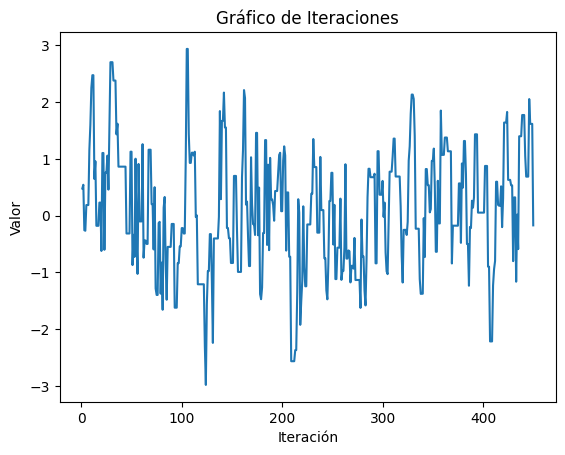

In [ ]:
plt.plot(range(1, len(x)+1), x)
plt.xlabel("Iteración")
plt.ylabel("Valor")
plt.title("Gráfico de Iteraciones")
plt.show()

- Los gráficos de trazas muestran cómo el valor de $\delta$ afecta el comportamiento del muestreador:
  - Con un $\delta$ pequeño:
    - Mayor movimiento entre iteraciones.
    - Pasos más pequeños.
    - Mayor autocorrelación en la cadena.
  - Con un $\delta$ grande:
    - Propuestas más alejadas del estado actual.
    - Mayor probabilidad de rechazo si las propuestas no son consistentes con la distribución objetivo.
- La teoría garantiza que ambas configuraciones ($\delta$ pequeño y grande) convergen a la misma distribución.
- Sin embargo, el valor de $\delta$ influye en:
  - La velocidad de convergencia.
  - La cantidad de espacio muestral explorado.
- Ajustar adecuadamente $\delta$ es clave para mejorar la eficiencia del muestreador.


### **5.3 distribución Bivariada:**

Sea $U(\mathbf{z})=\cfrac{1}{2}\cdot \left(\cfrac{\|\mathbf{z}-2\|^2}{0.4}\right)-\log \left(e^{-0.5\left[\frac{z_1-2}{0.6}\right]}+e^{-0.5\left[\frac{z_1+2}{0.6}\right]}\right)$; y $p(\mathbf{z})=e^{-U(\mathbf{z})}$ la distribución no normalizada que se quiere muestrear.

In [ ]:
def U(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

In [ ]:
# Graficamos la densidad real:
r = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = U(z)
plt.hexbin(z[:,0], z[:,1], C=q0.squeeze(), cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

* **Utilicemos el algoritmo Metropolis-Hastings (MH) con una densidad propuesta normal multivariada.**

In [ ]:
from tqdm import tqdm
def M_H(dens_prop, size=500000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        y = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (dens_prop(y))/(dens_prop(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = y
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples


In [ ]:
samples = M_H(U)

**Graficamos la muestra obtenida:**

In [ ]:
plt.hexbin(samples[:,0], samples[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

## **6. Muestreo de Gibss**

El muestreo de Gibbs es un método de muestreo utilizado en simulaciones basadas en cadenas de Markov (MCMC) para generar muestras de una distribución conjunta compleja. Funciona generando muestras secuencialmente de las distribuciones condicionales de cada variable, manteniendo fijas las demás variables.


### **6.1 Muestreo de Gibbs para una distribución bivariada normal.**

Vamos a considerar una distribución bivariada normal con media $\mathbf{\mu}^T=[\mu_1, \mu_2]$ y matriz de covarianza $\Sigma$.

La forma de esta distribución es:

* En forma matricial:

$$
f(\mathbf{x}) = \frac{1}{2\pi |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})\right),
$$

* En forma desarrollada:
$$f(x_1, x_2) = \frac{1}{2\pi \sigma_1\sigma_2 \sqrt{1 - \rho^2}}
\exp\left( -\frac{1}{2(1 - \rho^2)}
\left[ \frac{(x_1 - \mu_1)^2}{\sigma_1^2}
- 2\rho \frac{(x_1 - \mu_1)(x_2 - \mu_2)}{\sigma_1 \sigma_2}
+ \frac{(x_2 - \mu_2)^2}{\sigma_2^2} \right] \right).$$

* **Pasos del muestreo de Gibbs:**
1. Inicializar valores de $\left(X_1, X_2\right)$.
2. Muestra $X_1^{(t+1)}\sim P\left(X_1| X_2^{(t)}\right).$

Muestra: $X_2^{(t+1)}\sim P\left(X_2| X_1^{(t+1)}\right).$
3. Repetir el proceso hasta alcanzar la convergencia.

Para poder implementar este método, es necesario conocer las distribuciones condicionales:
* $X_1|X_2=x_2\sim \mathcal{N}\left(\mu_1+\rho \cdot (x_2-\mu_2)\cdot \cfrac{\sigma_1}{\sigma_2}; \left(1-\rho^2\right)\cdot \sigma_1^2\right)$.

* $X_2|X_1=x_1\sim \mathcal{N}\left(\mu_2+\rho \cdot (x_1-\mu_1)\cdot \cfrac{\sigma_2}{\sigma_1}; \left(1-\rho^2\right)\cdot \sigma_2^2\right)$

#### **6.1.1 Implementación de Códigos.**

* **Parámetros**

In [ ]:
mu1, mu2 = 0, 0  # Medias
sigma1, sigma2 = 1, 1  # Desviaciones estándar
rho = 0.8  # Correlación entre X1 y X2

* **Inicializamos con valores arbitrarios de $\left(X_1,X_2\right)$.**

In [ ]:
n = 2*10**6
x1_samples = np.zeros(n)
x2_samples = np.zeros(n)
x1_samples[0] = np.random.randn()
x2_samples[0] = np.random.randn()

* **Muestreo:**

En cada iteración, se genera un nuevo valor para $X_1$ condicionado a $X_2$, y luego se genera un nuevo valor para $X_2$ condicionado a $X_1$.

In [ ]:
for t in range(1, n):
    # Muestra X1 condicionado a X2
    x1_mean = mu1 + rho * (x2_samples[t-1] - mu2) * sigma1 / sigma2
    x1_std = np.sqrt((1 - rho**2) * sigma1**2)
    x1_samples[t] = np.random.normal(x1_mean, x1_std)

    # Muestra X2 condicionado a X1
    x2_mean = mu2 + rho * (x1_samples[t] - mu1) * sigma2 / sigma1
    x2_std = np.sqrt((1 - rho**2) * sigma2**2)
    x2_samples[t] = np.random.normal(x2_mean, x2_std)

x1_samples=x1_samples[1000:]
x2_samples=x2_samples[1000:]

* **Graficamos las muestras generadas:**

In [ ]:
plt.figure(figsize=(8, 6))
im, x_, y_ = np.histogram2d(x1_samples, x2_samples, bins=100, density=True)
plt.imshow(im, extent=[-10, 10, -10, 10], cmap='hot', origin='lower', interpolation='nearest')
plt.title('Muestras generadas con el muestreo de Gibbs')
plt.xlabel('X1')
plt.ylabel('X2')
plt.colorbar()
plt.show()


### **6.2 Aplicación en Estadística Bayesiana: Modelo Beta-Binomial**

Suiza tiene un sistema democrático semi-directo que permite a sus ciudadanos opinar sobre nuevas leyes en ciertas circunstancias. El 13 de junio de 2021, el electorado suizo votará sobre la iniciativa popular "Por una Suiza sin pesticidas artificiales". En resumen, cada ciudadano suizo podrá expresar su opinión (sí o no, aceptar o rechazar) sobre esa nueva ley y, si se alcanza una mayoría (> 50% de votos afirmativos), la nueva ley entrará en vigor.

El resultado de la votación es típicamente un experimento binomial en el sentido de que tenemos una serie de ensayos de Bernoulli independientes, con incertidumbre sobre $ p $, el parámetro que representa la probabilidad de un voto afirmativo. El 29 de abril, supongamos que tenemos un estudio inicial realizado con 1,000 ciudadanos suizos, que revela que el 44% de las personas encuestadas aceptarían la iniciativa popular y, por lo tanto, votarían sí. Supongamos además que el margen de error es de aproximadamente el 6%. Podríamos usar esa información para construir un modelo bayesiano jerárquico simple. El modelo es el siguiente:

$$y_i | p \sim \mathcal{B}(n, p_i)$$

$$p_i \sim \mathcal{Beta}(\alpha, \beta)$$
para $i = 1, \ldots, N$.

Supongamos que una variable aleatoria $Y$ sigue una distribución Binomial (una verosimilitud binomial para nuestros datos $y$), caracterizada por la función de probabilidad de masa:

$$f_p(y) = \pi(y \mid p) = \binom{n}{y} p^y (1 - p)^{n - y}$$

donde $p$ es el parámetro que representa la probabilidad de éxito en cada ensayo.

En estadística bayesiana, para modelar la incertidumbre sobre $p$, un prior conveniente sería la distribución Beta $\mathcal{Beta}(\alpha, \beta) $, ya que su soporte es el intervalo $[0, 1]$. La distribución Beta tiene la siguiente función de densidad de probabilidad:

$$f_{\alpha,\beta}(p) = \pi(p) = \frac{1}{B(\alpha, \beta)} p^{\alpha-1} (1 - p)^{\beta-1}
= \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1} (1 - p)^{\beta-1}$$

donde $\alpha$ y $\beta$ son parámetros de forma, $ B(\alpha, \beta)$ es la función Beta, y $\Gamma(\alpha)$ es la función Gamma, definida como:

$$\Gamma(\alpha) = \int_{0}^{\infty} y^{\alpha-1} e^{-y} \, dy = $$

La densidad Beta es una elección conveniente para la distribución de $p$, ya que puede adoptar una amplia variedad de formas.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

params = [(0.5, 0.5), (1, 1), (5, 1), (1, 5), (5, 5), (5, 40)]

p = np.linspace(0, 1, 500)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, (a, b) in enumerate(params):
    density = beta.pdf(p, a, b)
    axes[i].plot(p, density, color='blue')
    axes[i].set_title(f'Beta({a}, {b})', fontsize=12)
    axes[i].set_xlabel('p', fontsize=10)
    axes[i].set_ylabel('Densidad', fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Si $p\sim \mathcal{Beta}(\alpha, \beta)$, entonces:
$$E[p]=\cfrac{\alpha}{\alpha +\beta} \qquad \text{Var}(p)=\cfrac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$$

Se puede probar que la distribución a posteriori de $p\mid y$ también tiene distribución Beta con parámetros actualizados.
$$p\mid y\sim \mathcal{Beta}(y+\alpha, n-y+\beta)$$

Dado que tenemos información previa del estudio inicial, definimos $\alpha = 29.92$ y $\beta = 38.08$, de manera que la distribución a priori sobre $p$ esté centrada en 0.44 y tenga una desviación estándar de aproximadamente el 0.06.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import seaborn as sns

# Parámetros de la distribución Beta
alpha = 29.92
beta_param = 38.08

# Media de la distribución Beta
media = alpha / (alpha + beta_param)
print(f"Media: {media}")

# Desvío de la distribución Beta
desvio = np.sqrt((alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1)))
print(f"Desvío Estándar: {desvio}")

* Distribución a priori de $p$:

In [ ]:
p = np.linspace(0, 1, 100)
plt.plot(p, beta.pdf(p, alpha, beta_param), color="blue")
plt.xlabel("p")
plt.ylabel("Density(p)")
plt.title("Beta(29.92, 38.08)")
plt.show()

* Función Gibbs para simulaciones:

In [ ]:
import numpy as np
from scipy.stats import binom, beta

def gibbs_sampler(nsim, burn, alpha, beta_param, n):
    # Crear una matriz vacía para registrar los valores simulados
    X = np.zeros((nsim, 2))

    # Establecer los valores iniciales
    X[0, 0] = round(n * alpha / (alpha + beta_param))  # número inicial de votantes a favor
    X[0, 1] = alpha / (alpha + beta_param)  # probabilidad inicial p, la proporción de votantes a favor

    for i in range(1, nsim):
        # Muestreo de la distribución binomial condicional
        X[i, 0] = binom.rvs(n, X[i-1, 1])
        # Muestreo de la distribución beta condicional
        X[i, 1] = beta.rvs(alpha + X[i, 0], beta_param + n - X[i, 0])

    x = X[burn:, :]

    return x


* Realizamos las simulaciones con los datos del problema:

In [ ]:
np.random.seed(2024)
muestra_aleat = gibbs_sampler(nsim=11000, burn=1000, alpha=alpha, beta_param=beta_param, n=100)

* Podemos extrapolar estos datos a la población actual de Suiza (8960800 en 2024) con una tasa de participación en la votación del 40%.

In [ ]:
pob_votantes = 8960800 * 0.4
muestra_aleat_df = pd.DataFrame(muestra_aleat, columns=["yes_voters", "simulated_score"])
muestra_aleat_df["yes_voters"] = muestra_aleat_df["yes_voters"] * pob_votantes / 100

# Probabilidad de que la iniciativa popular sea aceptada
accepted_prob = len(muestra_aleat_df[(muestra_aleat_df["yes_voters"] > pob_votantes / 2) &
                                      (muestra_aleat_df["simulated_score"] > 0.5)]) / len(muestra_aleat_df)
print(f"Probabilidad de aceptación: {accepted_prob}")

In [ ]:
# Gráfico de dispersión entre votantes sí y la puntuación simulada
plt.figure(figsize=(10, 6))
sns.scatterplot(x=muestra_aleat_df["yes_voters"], y=muestra_aleat_df["simulated_score"], s=30, color='blue')
sns.regplot(x=muestra_aleat_df["yes_voters"], y=muestra_aleat_df["simulated_score"], scatter=False, color="red")
plt.xlabel("Votantes sí")
plt.ylabel("Puntuación simulada")
plt.title("Votantes sí vs Puntuación simulada")
plt.text(0.2, 0.8, f"R² = {muestra_aleat_df['yes_voters'].corr(muestra_aleat_df['simulated_score'])**2:.4f}", color="red", fontsize=12)
plt.show()

In [ ]:
# Histograma de puntuaciones simuladas
plt.figure(figsize=(10, 6))
sns.histplot(muestra_aleat_df['simulated_score'], kde=True, color="grey", stat="density", binwidth=0.01)
sns.kdeplot(muestra_aleat_df['simulated_score'], color="red", linewidth=2)
plt.xlabel("Puntuación simulada")
plt.ylabel("Densidad")
plt.title("Distribución de puntuaciones simuladas")
plt.show()


## **7. Naive Bayes**

Los métodos Naive Bayes son un conjunto de algoritmos de aprendizaje supervisado basados ​​en la aplicación del teorema de Bayes con el supuesto “ingenuo” de independencia condicional entre cada par de características dado el valor de la variable de clase.

### **7.1 Clasificación de tipos de vino con Naive Bayes**

Vamos a implementar el algoritmo Naive Bayes utilizando el conjunto de datos Wine, que es un conjunto clásico de clasificación que contiene información sobre la química de distintos tipos de vino.

El objetivo es clasificar el vino en tres tipos diferentes utilizando sus propiedades químicas.

Cargamos el conjunto de datos wine y revisaremos algunas características importantes como la forma de los datos y los nombres de las características.

In [ ]:
# Importamos bibliotecas necesarias
from sklearn.datasets import load_wine
import pandas as pd

# Cargamos el conjunto de datos Wine
wine = load_wine()

df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine['target'] = wine.target

* Veamos las primeras filas de la base:

In [ ]:
print(df_wine.head())

* Podemos acceder a la información de la base:

In [ ]:
df_wine.info()



* Obtengamos las estadísticas básicas de las variables:

In [ ]:
df_wine.describe()

#### **7.1.1 Análisis de la distribución de clases**

Es importante verificar el balance de clases antes de entrenar el modelo, dado que Naive Bayes podría verse afectado si las clases están muy desbalanceadas.

In [ ]:
# Contamos la cantidad de muestras por cada clase de vino
print(df_wine['target'].value_counts())


#### **7.1.2 Visualización de las características**

Análisis exploratorio visual para entender cómo se distribuyen las características en cada clase.

In [ ]:
features = df_wine.drop(columns='target').columns  # Selecciona todas las columnas excepto 'target'

# Ajustamos el tamaño de la figura para todos los gráficos
plt.figure(figsize=(15, 20))

# Recorremos todas las características (features)
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='target', y=feature, data=df_wine)
    plt.title(f'Boxplot de {feature}')
    plt.tight_layout()

plt.show()

#### **7.1.3 Entrenemos el modelo Naive Bayes**

Procedemos a dividir los datos en conjuntos de entrenamiento y prueba y entrenamos el modelo Naive Bayes.

In [ ]:
# Importamos las bibliotecas necesarias para el modelo
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
#https://scikit-learn.org/1.5/modules/naive_bayes.html
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3, random_state=42) #30% de datos de test

# Creamos el modelo Naive Bayes Gaussiano
model = GaussianNB()

# Entrenamos el modelo
model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = model.predict(X_test)

#### **7.1.4 Evaluación del modelo**

Ahora evaluamos el rendimiento del modelo utilizando métricas comunes, como la precisión global, el reporte de clasificación y la matriz de confusión.

1. **Precisión**: La precisión nos da una idea general del porcentaje de aciertos del modelo.
2. **Reporte de Clasificación**: Nos proporciona precisión, recall y F1-score, que son más detallados y permiten entender el rendimiento en cada clase.
3. **Matriz de Confusión**: Nos muestra cómo el modelo clasifica cada clase y dónde comete errores.

In [ ]:
# Precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=wine.target_names))

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))


#### **7.1.4 Interpretación de los resultados**

1. **Precisión**:
El valor de precisión (por ejemplo, 95%) nos indica qué tan bien está funcionando el modelo en términos generales. Sin embargo, no debemos basar nuestra evaluación solo en la precisión general, ya que puede ocultar detalles importantes si las clases están desbalanceadas.

2. **Reporte de clasificación**:
Este reporte nos muestra la precisión, recall y F1-score para cada clase de vino.

*Precisión* : El número de verdaderos positivos dividido entre el número total de positivos predichos (indicando cuántos de los positivos predichos eran realmente positivos).

*Recall* : El número de verdaderos positivos dividido entre el número total de positivos reales (indicando cuántos de los verdaderos positivos fueron correctamente identificados por el modelo).

*F1-score* : El promedio ponderado de la precisión y el recall. Es útil cuando las clases están desbalanceadas, ya que ofrece una única métrica para evaluar ambos aspectos.

3. **Matriz de confusión**:
La matriz de confusión nos muestra los verdaderos positivos (diagonal principal) y los errores de clasificación (valores fuera de la diagonal).


In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()


### **7.2 Aplicación de Naive Bayes a imágenes**

Base de datos extraida de: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data

Este conjunto de datos consiste en una lista con 2152 imágenes de alta resolución de plantas de papa que exhiben diversas enfermedades, incluyendo tizón temprano (early blight), tizón tardío (late blight) y hojas sanas (healthy).
Ha sido recopilado para ayudar en el desarrollo y prueba de modelos de reconocimiento de imágenes para una detección y clasificación precisa de enfermedades, promoviendo avances en el diagnóstico agrícola.

La base de datos contiene, entonces:
* 1000 imágenes RGB de tamaño 256x256 pixeles de hojas con **tizón temprano (EB)**.
* 1000 imágenes RGB de tamaño 256x256 pixeles de hojas con **tizón tardío (LB)**.
* 152 imágenes RGB de tamaño 256x256 pixeles de hojas **sanas (h)**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Lectura de archivo
X = np.load('/content/drive/MyDrive/DIPLOMATURA/3. Muestreo/imagenes.npy')

print(X.shape)

(2152, 256, 256, 3)


In [ ]:
etiquetas_EB = ["EB"] * 1000
etiquetas_LB = ["LB"] * 1000
etiquetas_H = ["H"] * 152
y = etiquetas_EB + etiquetas_LB + etiquetas_H
y=np.array(y)

In [ ]:
indices = np.concatenate([np.arange(2), np.arange(1000, 1002), np.arange(2000, 2002)])

plt.figure(figsize=(15, 12))

for i, indice in enumerate(indices):
    plt.subplot(3, 2, i + 1)
    plt.imshow(X[indice])
    plt.title(y[indice])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X_train,X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_trainNB = X_train.reshape(X_train.shape[0], -1)
X_testNB = X_test.reshape(X_test.shape[0], -1)

In [ ]:
#Categorías y balance en la base de prueba.
unicost, cantidadt = np.unique(y_test, return_counts = True)

print(f'El dataset de prueba posee imágenes de los siguentes tipos de hojas: {unicost}, y a cada tipo de hoja le corresponde la siguente cantidad: {cantidadt}')

In [ ]:
model = GaussianNB()

# Entrenamos el modelo
model.fit(X_trainNB, y_train)

# Hacemos predicciones
y_pred = model.predict(X_testNB)

In [ ]:
# Precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=wine.target_names))


In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

#### **7.2.1  Balanceo de la clase minoritaria utilizando Data Augmentation**

In [ ]:
from imgaug import augmenters as iaa
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5), # Flip horizontal con probabilidad 50%
    iaa.Affine(rotate=(-20, 20)), # Rotación entre -20 y 20 grados
    iaa.Multiply((0.8, 1.2)) # Cambios aleatorios en el brillo
])

# Aumentar la clase minoritaria
img = X[2002,:,:]

# Generar imágenes aumentadas
X_augmented = []

for _ in range(3):
    augmented_img = augmenter(image=img)
    X_augmented.append(augmented_img)
X_augmented = np.array(X_augmented)

print(X_augmented.shape)

In [ ]:
plt.figure(figsize=(15, 10))
# Mostrar la imagen original
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Imagen Original',fontsize=22)
plt.axis('off')

# Mostrar imágenes modificadas
plt.subplot(2, 2, 2)
plt.imshow(X_augmented[0,:,:])
plt.title('Primera Imagen modificada',fontsize=22)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X_augmented[1,:,:])
plt.title('Segunda Imagen modificada',fontsize=22)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X_augmented[2,:,:])
plt.title('Tercera Imagen modificada',fontsize=22)
plt.axis('off')

# Ajustar el diseño y mostrar todas las imágenes
plt.tight_layout()
plt.show()

**Balanceamos las clases:**

In [ ]:
from imgaug import augmenters as iaa

# Definir el aumento de datos
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5), # Flip horizontal con probabilidad 50%
    iaa.Affine(rotate=(-20, 20)), # Rotación entre -20 y 20 grados
    iaa.Multiply((0.8, 1.2)) # Cambios aleatorios en el brillo
])

X_minority = X[np.where(y == 'H')[0]]
y_minority = y[np.where(y == 'H')[0]]

X_augmented = []
y_augmented = []

for img in X_minority:
    for _ in range(5):  # Generar 5 aumentos por imagen
        augmented_img = augmenter(image=img)
        X_augmented.append(augmented_img)
        y_augmented.append('H')

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_b = np.concatenate((X, X_augmented), axis=0)
y_b = np.concatenate((y, y_augmented), axis=0)

**Repetir la implementación de Naive Bayes en la nueva base de datos, y comparar los resultados.**

In [ ]:
#########
# TO DO #
#########